In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50V2, EfficientNetB3

tf.random.set_seed(2345)

In [2]:
train_path = Path("fruits-360", "Training")
test_path = Path("fruits-360", "Test")

In [3]:
train_image_path = train_path.glob("*/*")
train_image_path = list(map(lambda x: str(x), train_image_path))
train_image_path[:10]

['data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\0_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\100_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\101_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\102_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\103_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\104_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\105_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\106_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\107_100.jpg',
 'data\\fruits-360_dataset\\fruits-360\\Training\\Apple Braeburn\\108_100.jpg']

In [4]:
def get_label(image_path):
    return image_path.split("/")[-2]

train_image_label = list(map(lambda x: get_label(x), train_image_path))
train_image_label[:10]

['Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn']

In [5]:
le = LabelEncoder()
train_image_label = le.fit_transform(train_image_label)
train_image_label[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [6]:
train_image_label = tf.keras.utils.to_categorical(train_image_label)
train_image_label[:10]

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train_image_path, train_image_label)

In [13]:
X_train[:5], y_train[:5]

(['data\\fruits-360_dataset\\fruits-360\\Training\\Peach Flat\\192_100.jpg',
  'data\\fruits-360_dataset\\fruits-360\\Training\\Grape White 4\\251_100.jpg',
  'data\\fruits-360_dataset\\fruits-360\\Training\\Banana Lady Finger\\189_100.jpg',
  'data\\fruits-360_dataset\\fruits-360\\Training\\Grape Blue\\r_70_100.jpg',
  'data\\fruits-360_dataset\\fruits-360\\Training\\Grape White 2\\54_100.jpg'],
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.,

In [15]:
def load(image, label = None):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels = 3)
    
    if label != None:
        return image, label
    else:
        return image

In [16]:
image_size = 224
batch_size = 32

resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(height = image_size,
                                                        width = image_size)
])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor = 0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(path, label, training = True):
    image_path = tf.convert_to_tensor(path)
    image_label = tf.convert_to_tensor(label)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_path)
    label_dataset = tf.data.Dataset.from_tensor_slices(image_label)

    fruits_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

    fruits_dataset = fruits_dataset.map(lambda image, label: load(image, label))
    fruits_dataset = fruits_dataset.map(lambda image, label: (resize(image), label), num_parallel_calls = AUTOTUNE)
    fruits_dataset = fruits_dataset.shuffle(1000)
    fruits_dataset = fruits_dataset.batch(batch_size)

    if training:
        fruits_dataset = fruits_dataset.map(lambda image, label: (data_augmentation(image), label), num_parallel_calls = AUTOTUNE)

    fruits_dataset = fruits_dataset.repeat()
    return fruits_dataset


In [18]:
train_dataset = get_dataset(X_train, y_train)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Maracuja


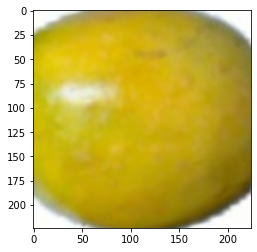

In [19]:
print(le.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224, 224, 3))

In [20]:
val_dataset = get_dataset(X_val, y_val, training = False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Kohlrabi


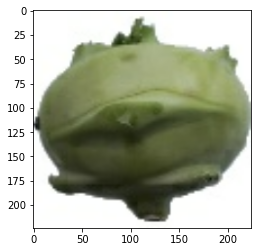

In [21]:
print(le.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224, 224, 3))

In [18]:
backbone = ResNet50V2(
    input_shape = (224, 224, 3),
    include_top = False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(131, activation = "softmax")
])

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 131)               268419    
Total params: 23,833,219
Trainable params: 23,787,779
Non-trainable params: 45,440
_________________________________________________________________


In [19]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "categorical_crossentropy",
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
)

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch = len(X_train)//batch_size,
    epochs = 1,
    validation_data = val_dataset,
    validation_steps = len(X_val)//batch_size)

1586/1586 [==============================] - 1101s 667ms/step - loss: 0.4535 - accuracy: 0.8730 - precision: 0.9331 - recall: 0.8383 - val_loss: 3.2227 - val_accuracy: 0.4560 - val_precision: 0.4955 - val_recall: 0.4276


In [20]:
model.layers[0].trainable = False

In [21]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", 
                                                verbose = 1,
                                                save_best_only = True,
                                                save_weights_only = True)

early_stop = tf.keras.callbacks.EarlyStopping(patience = 4)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 131)               268419    
Total params: 23,833,219
Trainable params: 268,419
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
history = model.fit(
    train_dataset,
    steps_per_epoch = len(X_train)//batch_size,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = len(X_val)//batch_size
)

Epoch 1/8
1586/1586 [==============================] - 1111s 675ms/step - loss: 0.4394 - accuracy: 0.8766 - precision: 0.9360 - recall: 0.8421 - val_loss: 3.8090 - val_accuracy: 0.4962 - val_precision: 0.5348 - val_recall: 0.4708

Epoch 00001: val_loss improved from inf to 3.80900, saving model to best_weights.h5
Epoch 2/8
1586/1586 [==============================] - 1073s 675ms/step - loss: 0.0831 - accuracy: 0.9746 - precision: 0.9773 - recall: 0.9717 - val_loss: 1.4002 - val_accuracy: 0.7096 - val_precision: 0.7447 - val_recall: 0.6887

Epoch 00002: val_loss improved from 3.80900 to 1.40015, saving model to best_weights.h5
Epoch 3/8
1586/1586 [==============================] - 1071s 676ms/step - loss: 0.0639 - accuracy: 0.9804 - precision: 0.9824 - recall: 0.9785 - val_loss: 5.7376 - val_accuracy: 0.3929 - val_precision: 0.4220 - val_recall: 0.3774

Epoch 00003: val_loss did not improve from 1.40015
Epoch 4/8
1586/1586 [==============================] - 1070s 675ms/step - loss: 0.04

In [31]:
model.save("fruits_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tf.keras.models.load_model("fruits_model.h5")

OSError: ignored

In [22]:
test_image_path = list(map(lambda x: str(x), list(test_path.glob("*/*"))))
test_labels = list(map(lambda x: get_label(x), test_image_path))

In [24]:
test_labels[:5]

['Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn',
 'Apple Braeburn']

In [25]:
test_image_path = list(map(lambda x: str(x), list(test_path.glob("*/*"))))
test_labels = list(map(lambda x: get_label(x), test_image_path))

test_labels = le.fit_transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_path = tf.convert_to_tensor(test_image_path)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_path, test_labels))
    .map(decode_image)
    .batch(batch_size)
)

In [26]:
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 131)


Apple Braeburn


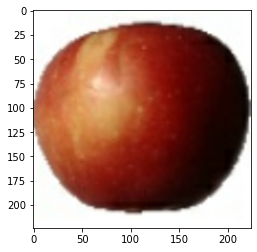

In [27]:
print(le.inverse_transform(np.argmax(label, axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224, 224, 3))

In [46]:
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

709/709 [==============================] - 137s 193ms/step - loss: 3.6110 - accuracy: 0.5120 - precision: 0.5320 - recall: 0.4967
 Testing Acc :  0.5119886994361877
 Testing Precision  0.5320334434509277
 Testing Recall  0.49669429659843445


In [28]:
def load_image(image_path):
    image = load(image_path)
    image = tf.image.resize(image, [224,224], method = "bilinear")
    plt.imshow(image.numpy()/255)
    image = tf.expand_dims(image, 0)
    return image

def real_time_prediction(image_path, model, encoder_method):
    image = load_image(image_path)
    prediction = model.predict(image)
    prediction = np.argmax(prediction, axis = 1)
    return encoder_method.inverse_transform(prediction)[0]

'Apple Braeburn'

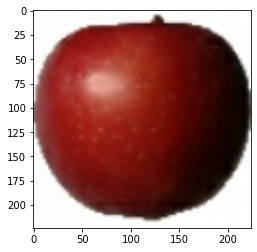

In [55]:
real_time_prediction("/content/fruits-360/Training/Apple Braeburn/100_100.jpg" , model , le)

EFFICIENTNET

In [29]:
backbone_ef = EfficientNetB3(
    input_shape = (224, 224, 3),
    include_top = False
)

model_ef = tf.keras.Sequential([
    backbone_ef,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(131, activation = "softmax")
])

model_ef.summary()

43941888/43941136 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 7, 7, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 131)               16899     
Total params: 10,997,170
Trainable params: 10,909,867
Non-trainable params: 87,303
_________________________________________________________________


In [30]:
model_ef.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = "categorical_crossentropy",
    metrics = ["accuracy", tf.keras.metrics.Precision(name = "precision"), tf.keras.metrics.Recall(name = "recall")]
)

In [31]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights_ef.h5", 
                                                verbose = 1,
                                                save_best_only = True,
                                                save_weights_only = True)

early_stop = tf.keras.callbacks.EarlyStopping(patience = 4)

In [32]:
history_ef = model_ef.fit(
    train_dataset,
    steps_per_epoch = len(X_train)//batch_size,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = len(X_val)//batch_size
)

Epoch 1/8
   3/1586 [..............................] - ETA: 14:33:05 - loss: 4.8604 - accuracy: 0.0104 - precision: 0.0000e+00 - recall: 0.0000e+00   

KeyboardInterrupt: 

In [ ]:
history_fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (20, 3), sharex=True)
history_fig.suptitle("ResNet Training performance")
ax1.plot(range(0,10), history.history["accuracy"], color= "blue")
ax1.plot(range(0,10), history_ef.history["accuracy"], color = "red")
ax1.set(ylabel = "Accuracy")
ax2.plot(range(0,10), history.history["loss"], color = "blue")
ax2.plot(range(0,10), history.history["val_loss"], color = "red", alpha = 0.9)
ax2.set(ylabel = "ResNet loss", xlabel = "Training Epoch")
ax3.plot(range(0,10), history_ef.history["loss"], color="blue")
ax3.plot(range(0,10), history_ef.history["val_loss"], color = "red", alpha = 0.9)
ax3.set(ylabel = "EfficientNet loss", xlabel = "Training Epoch")
ax4.plot(range(0,10), history.history["val_loss"], color = "blue")
ax4.plot(range(0,10), history_ef.history["val_loss"], color = "red")
history_fig

In [ ]:
loss, acc, prec, rec = model_ef.evaluate(test_dataset)

In [ ]:
real_time_prediction("/content/fruits-360/Training/Mandarine/220_100.jpg" , model_ef , le)